In [1]:
################ select features using random forest and then apply lstm #################

In [2]:
# 1. Import libraries:
%matplotlib inline
import os
import quandl
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as spo
from scipy.stats import kurtosis, skew
import seaborn as sns
# from financial_data import *
import tensorflow as tf
mlp.style.use('seaborn')
quandl.save_key('HtwBLPt3k37yZHTvy15K')

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/4242266090.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mlp.style.use('seaborn')


In [3]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(sp_url, header=0)[0]
sp500.head()



,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
# Correct invalid dates:
sp500.loc[sp500[sp500['Date added']=='1983-11-30 (1957-03-04)'].index,'Date added'] = '1983-11-30'
sp500.loc[sp500[sp500['Date added']=='2001?'].index,'Date added'] = '2001-01-01'
# Filter firms that entered the index after December 2015:
sp500['Date added'] = pd.to_datetime(sp500['Date added'],format='%Y-%m-%d')
sp500 = sp500[sp500['Date added']<'2007-01-01']
print("The number of stocks in the universe is:", sp500.shape[0])

The number of stocks in the universe is: 241


In [5]:
n_stocks = 5
np.random.seed(2)
universe_tickers = sp500['Symbol'].unique()
tickers = list(np.random.choice(universe_tickers,replace=False,size=n_stocks))
print(tickers)

['BK', 'CTAS', 'T', 'CSCO', 'MRK']


In [6]:
# # 'data' will be a Pandas DataFrame containing the historical data for the specified tickers
def download_data(tickers, start_date, end_date, columns):
    data = yf.download(tickers, start=start_date, end=end_date)
    data=data[columns]
    return data

# Define the tickers, start date, end date, and columns you want to download
# tickers = ['AAPL', 'GOOGL', 'MSFT']
start_date = '2007-01-01'
end_date = '2022-12-31'
columns = [ 'Adj Close', 'Volume','Open','High','Low']

# Download the data
data = download_data(tickers, start_date, end_date, columns)
# print(data)


def one_lvl_colnames(df,cols,tickers):
    """This function changes a multi-level column indexation into a one level
    column indexation

    Inputs:
    -------
    df (pandas Dataframe): dataframe with the columns whose indexation will be 
        flattened.
    tickers (list|string): list/string with the tickers (s) in the data frame df.
    cols (list|string): list/string with the name of the columns (e.g. 'Adj Close',
        'High', 'Close', etc.) that are in the dataframe df.
    
    Ouputs:
    -------
    df (pandas Dataframe): dataframe with the same information as df, but 
        with one level of indexation.
    """
    
    df_not_renamed=df.copy()
    # Define important variables:
    if isinstance(tickers, str):
        tickers = [tickers]
    if isinstance(cols, str):
        
        cols = [cols]
    # For multi-level column indexing:
    if isinstance(df.columns.values[0], tuple):

        # Define important varibles
        columns = df.columns.values
        new_cols = []

        # Itarate through the multi-level column names and flatten them:
        for col in columns:
            temp = []
            for name in col:
                if name != '':
                    temp.append(name)
            new_temp = '_'.join(temp)
            new_cols.append(new_temp)
        
        # Change the column names:
        df.columns = new_cols
#         print(df.columns)
    
    # For uni-level colum indexing:
    elif isinstance(df.columns.values[0], str):
        
        # Define new names:
        col_names = [column+'_'+ticker for column in cols\
                     for ticker in tickers]
        df.columns = col_names
    
#     print("the dataframe after the columns have been renamed") 
#     print(df)

    return df

df2=pd.DataFrame(one_lvl_colnames(data,cols=columns,tickers=tickers))
df2_columns=list(df2.columns)
df2.columns = [col.replace('Adj Close', 'Close') for col in df2_columns]
df2

[*********************100%%**********************]  5 of 5 completed


,Close_BK,Close_CSCO,Close_CTAS,Close_MRK,Close_T,Volume_BK,Volume_CSCO,Volume_CTAS,Volume_MRK,Volume_T,...,High_BK,High_CSCO,High_CTAS,High_MRK,High_T,Low_BK,Low_CSCO,Low_CTAS,Low_MRK,Low_T
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,28.612906,19.106241,31.573709,23.187099,7.615343,5236908,64226000,1831200,15740226,44611253,...,42.558830,27.980000,41.290001,42.833969,27.024170,41.986431,27.330000,39.680000,41.956108,26.268883
2007-01-04,28.555241,19.609221,31.604942,23.761238,7.517288,5846816,73012100,793000,13115930,58633870,...,42.209030,28.490000,40.770000,43.368320,26.616314,41.604836,27.540001,39.970001,41.622135,25.732628
2007-01-05,28.418259,19.616112,31.464371,23.334589,7.399628,4854359,62647800,1139400,11168431,48407823,...,42.336231,28.570000,40.669998,43.034351,26.087612,41.488235,28.049999,39.930000,42.156490,25.641994
2007-01-08,28.533615,19.726355,31.495619,23.329329,7.470334,3788223,47936500,734900,7384522,53274318,...,42.081833,28.740000,40.520000,42.480915,25.687311,41.445835,28.320000,40.000000,41.183205,25.083082
2007-01-09,28.411062,19.616112,31.440939,23.113361,7.499059,4139828,50488300,792300,9037114,53069362,...,42.187832,28.750000,40.590000,42.461830,25.989426,41.414036,28.309999,39.959999,41.822517,25.422960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,43.078903,46.067886,453.706879,109.603188,17.157434,2273400,9554400,205100,4547400,25164100,...,44.709999,47.490002,457.489990,112.129997,18.320000,44.200001,47.009998,448.010010,110.870003,18.100000
2022-12-27,43.242916,46.116402,455.483063,109.857956,17.297995,2109600,12066200,317600,5125800,30382500,...,44.919998,47.709999,462.029999,112.589996,18.520000,44.509998,47.220001,455.940002,111.529999,18.219999
2022-12-28,43.059605,45.670082,447.554810,108.838928,17.073103,2013100,9847400,265700,5107800,26632300,...,44.930000,47.770000,464.630005,112.889999,18.549999,44.560001,46.980000,450.959991,111.059998,18.190001


In [7]:
pd.set_option('display.max_rows', 100)

In [8]:
from stockstats import StockDataFrame
def extract_and_wrap_ticker_data(df, columns):
    # Split column names into parts
    parts = [col.split('_') for col in columns]

    # Create a dictionary to store information about each ticker
    ticker_info = {}

    # Iterate through the parts list
    for part in parts:
        data_type = part[0]  # e.g., 'Adj Close', 'Close', etc.
        ticker = part[1]     # e.g., 'AAPL', 'GOOGL', etc.

        # Check if the ticker is already in the dictionary
        if ticker not in ticker_info:
            ticker_info[ticker] = {}

        # Add information for the ticker
        ticker_info[ticker][data_type] = df[f'{data_type}_{ticker}']

    # Create a dictionary to store stockstats DataFrames for each ticker
    ticker_dataframes = pd.DataFrame()
#     var_importance_all=

    # Iterate through ticker_info and wrap data with stockstats
    for ticker, data in ticker_info.items():
        df = pd.DataFrame(data)
        print(ticker)
        
        stock_df = StockDataFrame.retype(df)
#         print(stock_df)

        stock_df.init_all()
        stock_df.drop(columns=['tp','rate','change'],inplace=True)
        
        stock_df.columns = [ticker+"_" + col for col in pd.DataFrame(stock_df).columns]
        ticker_dataframes = pd.concat([ticker_dataframes,stock_df],axis=1)
        
    return ticker_dataframes

# Sample DataFrame with specified columns
columns = list(df2.columns)
# print(columns)



# Extract and wrap ticker data
ticker_dataframes = extract_and_wrap_ticker_data(df2, columns)

# Access information for a specific ticker (e.g., AAPL)
# print(ticker_dataframes)

ticker_dataframes

BK
CSCO
CTAS
MRK
T


,BK_close,BK_volume,BK_open,BK_high,BK_low,BK_middle,BK_boll,BK_boll_ub,BK_boll_lb,BK_macd,...,T_pgo,T_psl,T_rsi,T_rsv,T_stochrsi,T_tema,T_trix,T_wr,T_vr,T_vwma
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,28.612906,5236908,42.113632,42.558830,41.986431,37.719389,28.612906,NaN,NaN,0.000000,...,0.000000,0.000000,NaN,-2469.728186,NaN,7.615343,0.000000,-2569.728186,100.000000,20.302798
2007-01-04,28.555241,5846816,41.975834,42.209030,41.604836,37.456369,28.584073,28.665624,28.502523,-0.001294,...,-0.002555,0.000000,0.000000,-1410.355909,NaN,7.523564,-0.204632,-1510.355909,27.558395,20.105513
2007-01-05,28.418259,4854359,41.869835,42.336231,41.488235,37.414242,28.528802,28.728763,28.328840,-0.005896,...,-0.005863,0.000000,0.000000,-1319.830009,NaN,7.411027,-0.243725,-1419.830009,17.244754,19.979184
2007-01-08,28.533615,3788223,41.795631,42.081833,41.445835,37.353761,28.530005,28.693344,28.366666,-0.003680,...,-0.001617,8.333333,26.730908,-907.364897,100.000000,7.443603,-0.202635,-1007.364897,58.431783,19.832144
2007-01-09,28.411062,4139828,41.891033,42.187832,41.414036,37.337643,28.506216,28.683212,28.329221,-0.007275,...,-0.000068,16.666667,34.402769,-905.885025,100.000000,7.481023,-0.158881,-1005.885025,99.460358,19.792034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,43.078903,2273400,44.439999,44.709999,44.200001,43.996301,43.103985,44.430427,41.777542,0.248976,...,-0.277267,50.000000,45.138188,-25.944342,33.679423,17.106574,-0.074204,-125.668333,128.832253,18.268824
2022-12-27,43.242916,2109600,44.810001,44.919998,44.509998,44.224304,43.104949,44.431786,41.778113,0.251036,...,-0.128523,58.333333,48.249597,-23.424969,44.977801,17.252378,-0.094972,-118.191733,127.544190,18.227175
2022-12-28,43.059605,2013100,44.820000,44.930000,44.560001,44.183202,43.094819,44.419692,41.769946,0.235166,...,-0.248041,58.333333,43.954382,-48.452684,31.116489,17.155718,-0.112708,-130.154049,112.830020,18.167253


In [10]:
# Define the tickers
new_tickers = ['FRED/T10Y2Y','FRED/T10Y3M','FRED/DTB3','FRED/DLTIIT','FRED/TEDRATE']

names = ['10y2y_spread','10y3m_spread','3m_rate','ltiit','ted_spread']
# # Retrieve data
data_quandl = quandl.get(new_tickers, start_date=start_date, end_date=end_date)
data_quandl.columns = names
# # Print the data
print(data_quandl)



            10y2y_spread  10y3m_spread  3m_rate  ltiit  ted_spread
Date                                                              
2007-01-02         -0.12         -0.39     4.94   2.33        0.42
2007-01-03         -0.09         -0.38     4.92   2.32        0.44
2007-01-04         -0.09         -0.42     4.91   2.30        0.45
2007-01-05         -0.11         -0.40     4.92   2.33        0.44
2007-01-08         -0.12         -0.42     4.95   2.34        0.41
...                  ...           ...      ...    ...         ...
2022-07-12         -0.07          0.74     2.16   1.12         NaN
2022-07-13         -0.22          0.52     2.33   1.06         NaN
2022-07-14         -0.19          0.56     2.33   1.07         NaN
2022-07-15         -0.20          0.56     2.29   1.03         NaN
2022-07-18         -0.19          0.46      NaN    NaN         NaN

[3891 rows x 5 columns]


In [11]:
temp=ticker_dataframes.reset_index()
max_date=data_quandl.reset_index()['Date'].max()
temp=temp[temp['Date']<=max_date]
temp

,Date,BK_close,BK_volume,BK_open,BK_high,BK_low,BK_middle,BK_boll,BK_boll_ub,BK_boll_lb,...,T_pgo,T_psl,T_rsi,T_rsv,T_stochrsi,T_tema,T_trix,T_wr,T_vr,T_vwma
0,2007-01-03,28.612906,5236908,42.113632,42.558830,41.986431,37.719389,28.612906,NaN,NaN,...,0.000000,0.000000,NaN,-2469.728186,NaN,7.615343,0.000000,-2569.728186,100.000000,20.302798
1,2007-01-04,28.555241,5846816,41.975834,42.209030,41.604836,37.456369,28.584073,28.665624,28.502523,...,-0.002555,0.000000,0.000000,-1410.355909,NaN,7.523564,-0.204632,-1510.355909,27.558395,20.105513
2,2007-01-05,28.418259,4854359,41.869835,42.336231,41.488235,37.414242,28.528802,28.728763,28.328840,...,-0.005863,0.000000,0.000000,-1319.830009,NaN,7.411027,-0.243725,-1419.830009,17.244754,19.979184
3,2007-01-08,28.533615,3788223,41.795631,42.081833,41.445835,37.353761,28.530005,28.693344,28.366666,...,-0.001617,8.333333,26.730908,-907.364897,100.000000,7.443603,-0.202635,-1007.364897,58.431783,19.832144
4,2007-01-09,28.411062,4139828,41.891033,42.187832,41.414036,37.337643,28.506216,28.683212,28.329221,...,-0.000068,16.666667,34.402769,-905.885025,100.000000,7.481023,-0.158881,-1005.885025,99.460358,19.792034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3907,2022-07-12,39.601913,3144200,41.299999,42.750000,41.270000,41.207305,39.829926,41.139294,38.520558,...,-0.018935,41.666667,53.798476,-157.828054,17.207026,18.970152,0.144462,-154.368194,91.219707,20.180158
3908,2022-07-13,39.127861,3873900,41.209999,41.480000,40.650002,40.419287,39.820444,41.148055,38.492834,...,-0.103353,33.333333,50.884108,-120.834991,0.000000,18.840139,0.140839,-195.548596,91.685518,20.223174
3909,2022-07-14,38.340939,5075600,40.299999,40.639999,39.779999,39.586979,39.812860,41.173728,38.451991,...,-0.164390,33.333333,48.615201,-99.415554,0.000000,18.714834,0.130175,-199.415554,82.971678,20.234871
3910,2022-07-15,41.156780,4984700,41.720001,43.750000,41.189999,42.032260,39.885863,41.371434,38.400292,...,-0.043087,41.666667,53.117743,-87.496208,33.377626,18.828120,0.119776,-182.925531,82.757693,20.218003


In [12]:
final_df=pd.merge(temp,data_quandl.reset_index(),on=['Date'],how='left')
final_df

,Date,BK_close,BK_volume,BK_open,BK_high,BK_low,BK_middle,BK_boll,BK_boll_ub,BK_boll_lb,...,T_tema,T_trix,T_wr,T_vr,T_vwma,10y2y_spread,10y3m_spread,3m_rate,ltiit,ted_spread
0,2007-01-03,28.612906,5236908,42.113632,42.558830,41.986431,37.719389,28.612906,NaN,NaN,...,7.615343,0.000000,-2569.728186,100.000000,20.302798,-0.09,-0.38,4.92,2.32,0.44
1,2007-01-04,28.555241,5846816,41.975834,42.209030,41.604836,37.456369,28.584073,28.665624,28.502523,...,7.523564,-0.204632,-1510.355909,27.558395,20.105513,-0.09,-0.42,4.91,2.30,0.45
2,2007-01-05,28.418259,4854359,41.869835,42.336231,41.488235,37.414242,28.528802,28.728763,28.328840,...,7.411027,-0.243725,-1419.830009,17.244754,19.979184,-0.11,-0.40,4.92,2.33,0.44
3,2007-01-08,28.533615,3788223,41.795631,42.081833,41.445835,37.353761,28.530005,28.693344,28.366666,...,7.443603,-0.202635,-1007.364897,58.431783,19.832144,-0.12,-0.42,4.95,2.34,0.41
4,2007-01-09,28.411062,4139828,41.891033,42.187832,41.414036,37.337643,28.506216,28.683212,28.329221,...,7.481023,-0.158881,-1005.885025,99.460358,19.792034,-0.13,-0.42,4.95,2.35,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3907,2022-07-12,39.601913,3144200,41.299999,42.750000,41.270000,41.207305,39.829926,41.139294,38.520558,...,18.970152,0.144462,-154.368194,91.219707,20.180158,-0.07,0.74,2.16,1.12,NaN
3908,2022-07-13,39.127861,3873900,41.209999,41.480000,40.650002,40.419287,39.820444,41.148055,38.492834,...,18.840139,0.140839,-195.548596,91.685518,20.223174,-0.22,0.52,2.33,1.06,NaN
3909,2022-07-14,38.340939,5075600,40.299999,40.639999,39.779999,39.586979,39.812860,41.173728,38.451991,...,18.714834,0.130175,-199.415554,82.971678,20.234871,-0.19,0.56,2.33,1.07,NaN
3910,2022-07-15,41.156780,4984700,41.720001,43.750000,41.189999,42.032260,39.885863,41.371434,38.400292,...,18.828120,0.119776,-182.925531,82.757693,20.218003,-0.20,0.56,2.29,1.03,NaN


In [13]:
pd.DataFrame(final_df.isnull().sum()).sort_values(by=0,ascending=False)


,0
T_cr-ma1,3714
T_cr-ma2,3692
T_cr-ma3,3666
MRK_cr-ma1,3061
MRK_cr-ma2,2990
...,...
CSCO_mfi,0
CSCO_ker,0
CSCO_kdjj,0
CSCO_kdjd,0


In [14]:
final_df2=final_df.copy()

for ticker in tickers:
    final_df2[ticker+"_close"] = final_df2[ticker+"_close"].pct_change()
final_df2.fillna(method='ffill',inplace=True)
final_df2.fillna(method='bfill',inplace=True)

final_df2=final_df2.loc[14:]
final_df2.set_index(['Date'],inplace=True)

final_df2

,BK_close,BK_volume,BK_open,BK_high,BK_low,BK_middle,BK_boll,BK_boll_ub,BK_boll_lb,BK_macd,...,T_tema,T_trix,T_wr,T_vr,T_vwma,10y2y_spread,10y3m_spread,3m_rate,ltiit,ted_spread
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-24,0.007393,1680950,43.035828,43.364426,42.972229,38.655453,28.992064,29.913602,28.070526,0.138800,...,8.024645,0.149985,-523.639107,223.216724,19.959407,-0.12,-0.32,5.00,2.39,0.36
2007-01-25,-0.008317,5159266,43.194828,43.459827,42.919228,38.587444,29.016515,29.928040,28.104989,0.131370,...,8.130909,0.190789,-467.665100,247.198236,20.078565,-0.11,-0.27,5.01,2.43,0.35
2007-01-26,-0.005180,5972477,43.131226,43.300827,42.558830,38.363574,29.029135,29.917831,28.140440,0.114653,...,8.104169,0.225278,-469.645928,208.586970,20.176804,-0.11,-0.25,5.00,2.44,0.36
2007-01-29,-0.010166,5153794,42.590630,42.972229,42.081833,37.995986,29.023844,29.887174,28.160515,0.081707,...,8.098180,0.253873,-469.087264,221.276748,20.319304,-0.09,-0.24,5.01,2.46,0.35
2007-01-30,0.000752,2494255,42.580029,42.580029,42.166630,37.900768,29.020255,29.859844,28.180666,0.056789,...,8.178131,0.282790,-466.141550,233.937110,20.462249,-0.10,-0.25,5.00,2.43,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12,0.001439,3144200,41.299999,42.750000,41.270000,41.207305,39.829926,41.139294,38.520558,-0.530211,...,18.970152,0.144462,-154.368194,91.219707,20.180158,-0.07,0.74,2.16,1.12,0.09
2022-07-13,-0.011970,3873900,41.209999,41.480000,40.650002,40.419287,39.820444,41.148055,38.492834,-0.554956,...,18.840139,0.140839,-195.548596,91.685518,20.223174,-0.22,0.52,2.33,1.06,0.09
2022-07-14,-0.020112,5075600,40.299999,40.639999,39.779999,39.586979,39.812860,41.173728,38.451991,-0.630794,...,18.714834,0.130175,-199.415554,82.971678,20.234871,-0.19,0.56,2.33,1.07,0.09


In [15]:

pd.DataFrame(np.isinf(final_df2).sum()).sort_values(by=0,ascending=False).head(50)

,0
T_cr,3717
MRK_cr,3112
CSCO_cr,2922
BK_cr,2784
CTAS_cr,1938
BK_close,0
MRK_dx,0
MRK_supertrend_ub,0
MRK_wt2,0
MRK_wt1,0


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
def check_var_importance(df,ticker):
    # Separate features (X) and target (y)
    null_count=pd.DataFrame(df.isnull().sum()).sort_values(by=0,ascending=False).reset_index()
    null_count.columns=['features','nulls']
    null_count.head()
    threshold = len(df)/100

    # Get the column names with too many negative values
    columns_to_drop = null_count[null_count['nulls'] > threshold]['features'].tolist()
    print(columns_to_drop)
    # Drop the columns
    df.drop(columns=columns_to_drop, inplace=True)
    df.replace([np.inf, -np.inf], 0, inplace=True)

    df.ffill(inplace=True)
    df.bfill(inplace=True)
    print("**************************")
#     print(df.isnull())

    X = df  # Use relevant columns
    y = df[ticker+'_close']  # Target variable is 'Close'

    # Standardize features (optional but often recommended for neural networks)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Create sequences of length 5 for X and corresponding y for training
    X_train, y_train = [], []

    for i in range(5, len(X)):
        X_train.append(X[i-5:i])
        y_train.append(y[i])

    X_train, y_train = np.array(X_train), np.array(y_train)
    # Step 2: Check Variable Importance
    # Use RandomForestRegressor to determine importance
    rf = RandomForestRegressor(n_estimators=10)
    rf.fit(X_train.reshape(-1, 5 * X.shape[1]), y_train)

    # Get feature importances along with their corresponding feature names
    feature_importances = rf.feature_importances_
    print([feature_importances][0].tolist())
    feature_names = [col.split(ticker+"_")[-1] for col in df.columns]
    print(feature_names)

    # Combine feature names with their importances
    feature_importance_info = list(zip(feature_names, feature_importances))


    # Sort the list by importance (in descending order)
    feature_importance_info.sort(key=lambda x: x[0])

    return pd.DataFrame(feature_importance_info,columns=['Features',ticker+'_Relative_Importance'])

    

In [17]:
final_df2.head(2)
features=['close', 'volume', 'open', 'high', 'low', 'middle',
       'boll', 'boll_ub', 'boll_lb', 'macd', 'macds', 'macdh', 'pvo', 'pvos',
       'pvoh', 'ppo', 'ppos', 'ppoh', 'qqe', 'qqel', 'qqes', 'cr', 'cr-ma1',
       'cr-ma2', 'cr-ma3', 'tr', 'dx', 'adx', 'adxr', 'log-ret', 'wt1', 'wt2',
       'supertrend_ub', 'supertrend_lb', 'supertrend', 'bop', 'cti', 'eribull',
       'eribear', 'rvgi', 'rvgis', 'kst', 'ao', 'aroon', 'atr', 'cci',
        'chop', 'cmo', 'coppock', 'dma', 'ichimoku', 'inertia', 'ftr',
       'kama', 'kdjk', 'kdjd', 'kdjj', 'ker', 'mfi', 'ndi', 'pdi', 'pgo',
       'psl', 'rsi', 'rsv', 'stochrsi', 'tema', 'trix', 'wr', 'vr', 'vwma']
feat_importance_all=pd.DataFrame()
feat_importance_all['Features']=features
# print(feat_importance_all)
for ticker in tickers:
    
    matching_columns = [f'{ticker}_{i}' for i in features]
    print(matching_columns)

    temp_df=final_df2[matching_columns]
    feat_importance_temp=check_var_importance(temp_df,ticker)
    feat_importance_all=feat_importance_all.merge(feat_importance_temp, on=['Features'], how='left')
feat_importance_all=feat_importance_all.T.drop_duplicates(keep='first').T
feat_importance_all["Average_relative_Importance"]=feat_importance_all.iloc[:,1:].mean(axis=1)
feat_importance_all=feat_importance_all.sort_values(by=['Average_relative_Importance'], ascending=False).reset_index(drop=True)
print(feat_importance_all)



['BK_close', 'BK_volume', 'BK_open', 'BK_high', 'BK_low', 'BK_middle', 'BK_boll', 'BK_boll_ub', 'BK_boll_lb', 'BK_macd', 'BK_macds', 'BK_macdh', 'BK_pvo', 'BK_pvos', 'BK_pvoh', 'BK_ppo', 'BK_ppos', 'BK_ppoh', 'BK_qqe', 'BK_qqel', 'BK_qqes', 'BK_cr', 'BK_cr-ma1', 'BK_cr-ma2', 'BK_cr-ma3', 'BK_tr', 'BK_dx', 'BK_adx', 'BK_adxr', 'BK_log-ret', 'BK_wt1', 'BK_wt2', 'BK_supertrend_ub', 'BK_supertrend_lb', 'BK_supertrend', 'BK_bop', 'BK_cti', 'BK_eribull', 'BK_eribear', 'BK_rvgi', 'BK_rvgis', 'BK_kst', 'BK_ao', 'BK_aroon', 'BK_atr', 'BK_cci', 'BK_chop', 'BK_cmo', 'BK_coppock', 'BK_dma', 'BK_ichimoku', 'BK_inertia', 'BK_ftr', 'BK_kama', 'BK_kdjk', 'BK_kdjd', 'BK_kdjj', 'BK_ker', 'BK_mfi', 'BK_ndi', 'BK_pdi', 'BK_pgo', 'BK_psl', 'BK_rsi', 'BK_rsv', 'BK_stochrsi', 'BK_tema', 'BK_trix', 'BK_wr', 'BK_vr', 'BK_vwma']
[]
**************************


/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/2306489379.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/2306489379.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/2306489379.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

[0.014067120342223136, 0.006912500041885703, 0.0013310469890472454, 0.0011177688689892346, 0.000685186331943132, 0.00153277493790881, 0.0006117846850027151, 0.002641035837285437, 0.0011220421479675817, 0.0003279370216948265, 0.0014283995950147925, 0.0018764261786216505, 0.00706945842645942, 0.005001780974127303, 0.003059222061979278, 0.00024625008387229566, 0.002025159371556832, 0.0034199994783010988, 0.001177588093830033, 0.00046335292773834393, 0.0004301336633772249, 0.0016079393943772842, 0.002213448826164163, 0.0007206060677318388, 0.002734148712105074, 0.005219654730511702, 0.004948315601689805, 0.001245172711798907, 0.0018212199829915868, 0.013348127781854421, 0.0019397136239257134, 0.0035749325101180817, 3.3234630906705237e-05, 0.00015912187460440767, 0.0006090288618517451, 0.005595824988110925, 0.0059249620928962295, 0.0010510995342110972, 0.0012725330721140432, 0.0008725564375890163, 0.004080453621687805, 0.0023895984942019052, 0.0009717311289361569, 0.0019621819168709137, 0.0

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/2306489379.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/2306489379.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/2306489379.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

[0.01126538711821612, 0.007326219158680545, 0.00024987540720618825, 0.0018323792715363419, 0.004020636662238982, 0.0018214772497314742, 0.0007724910817593887, 0.0013373780878688363, 0.0027455698703233293, 0.0002480818151635603, 0.0011063266500187011, 0.003279472397575354, 0.004055033404219617, 0.005940097462653729, 0.00438682957416465, 0.0010194047261375266, 0.0028916058295567334, 0.006933537483009726, 0.0035649750037779473, 0.0007497187703842499, 0.0005647866062628127, 0.002048213553429772, 0.0009402942225275917, 0.0002782498443596933, 0.0020234476640962847, 0.004500839063676323, 0.005446741500958104, 0.004820965614330304, 0.004692740461917434, 0.006122399657946892, 0.004055459943600748, 0.0026559485865047137, 2.998027114736906e-05, 0.000639761327184857, 0.00010366847275300798, 0.00454787524243104, 0.004895148640217587, 0.0034288784972785528, 0.0030812127491295542, 0.0013726978526162337, 0.0018260960450649465, 0.0016436831314970818, 0.0007878145447236619, 0.002414125699332086, 0.00243

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/2306489379.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/2306489379.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/2306489379.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

[0.014414400399414004, 0.005138790229895615, 0.0009584529307715484, 0.0015485715913433405, 0.0015395459942986057, 0.0011903453794443297, 0.002172474035193242, 0.013940773345313393, 0.0024677371707470916, 0.0012820766355171168, 0.0010854613312500365, 0.003096726107613617, 0.0037689574690084405, 0.004315573791476564, 0.004909906664264498, 0.0033077556441982493, 0.0010639520206803487, 0.008461673248275207, 0.003061432907696755, 0.00037691896723202853, 0.0011121849224951636, 0.0008820538909043295, 2.477868771295921e-06, 0.00019902945377282323, 0.0005856450802545793, 0.0025326766879676223, 0.0030386066460459755, 0.002982165353025174, 0.0016183753057081494, 0.018612411624399593, 0.00020854670043433016, 0.001229440602656231, 0.00019747092008035624, 0.0003498367716503489, 0.0001444968947806026, 0.005201784380348215, 0.003606816932026213, 0.0019468750255051473, 0.002282601637405407, 0.0014887338995740842, 0.0003546157964643945, 0.001161809017374375, 0.004190055597469634, 0.00308581600643498, 0.

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/2306489379.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/2306489379.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/2306489379.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

[0.00833262021553549, 0.006433790838964597, 0.0018976513731043978, 0.0007856274895344963, 0.001621326090616943, 0.0009260364989961916, 0.00316847922168146, 0.0028812033551874994, 0.001517253729620653, 0.000580762379780213, 0.002073025278657961, 0.0023577133399781346, 0.0038693052473315367, 0.004643413044122643, 0.0039449327792616, 0.004985934096023052, 0.0034289886921177208, 0.0028926610979574468, 0.0016746398542376944, 0.0010549052708968155, 0.0004207483660725666, 0.001149945657976714, 0.0015263183568124778, 0.000593415935029276, 0.0006168480085945352, 0.00667923273335243, 0.004428458389406281, 0.0027912421821710233, 0.0031962210972799315, 0.006841074873746599, 0.001116082482461064, 0.0018282442462998142, 0.0006681720767007956, 0.00013325473901832784, 0.0015654065149486712, 0.008873741859096845, 0.007906732869197765, 0.004958101377138249, 0.0025773923666628615, 0.001368370934908974, 0.004641628009763221, 0.0021685720503726016, 0.0030255687808282772, 0.0013653099558150435, 0.0027357985

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/2306489379.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/2306489379.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], 0, inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/2306489379.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

[0.012420185167762172, 0.006237980122393414, 0.0017385621346792837, 0.0015664037759736435, 0.0036778302993583914, 0.0015303331961433757, 0.0016292262749656044, 0.0011830196692925725, 0.002176840529160615, 0.001612748422345944, 0.0012059026075489931, 0.0026772386058567673, 0.003742797379810363, 0.00299482013395833, 0.004044002322293249, 0.0014964777966272982, 0.0016090545616512923, 0.002421613462023958, 0.0031875884627022913, 0.0015435317383507786, 0.0016524403232374002, 0.00019670227231189272, 0.0002576374315385713, 0.0009159957880999159, 0.0018492770078789248, 0.0038466082387888538, 0.004183438409239306, 0.0024299768671210216, 0.003880937831363204, 0.008639886507660361, 0.0013471313417121082, 0.002389305302658684, 0.0012356423319823356, 0.00019908921658467384, 9.041915503833901e-05, 0.006700934327736194, 0.0015383707150648269, 0.004574776471010287, 0.0035298558034416597, 0.0004953035054147833, 0.0010464595476181778, 0.0021802566289039244, 0.0019129122553627749, 0.0033491938537393373, 

In [18]:
imp_features=list(feat_importance_all['Features'][:15])
imp_features
# feat_importance_all

['close',
 'log-ret',
 'volume',
 'vr',
 'bop',
 'cci',
 'ppoh',
 'ker',
 'cti',
 'pvos',
 'tr',
 'pvo',
 'dx',
 'boll_ub',
 'pvoh']

In [19]:
# imp_col_names=[filtered_df['Features'].values][0].tolist()

imp_features.append('close') if 'close' not in imp_features else imp_features
final_col_names = []
for col in imp_features:
    for ticker in tickers:
        final_col_names.append(f'{ticker}_{col}')

print(final_col_names)

['BK_close', 'CTAS_close', 'T_close', 'CSCO_close', 'MRK_close', 'BK_log-ret', 'CTAS_log-ret', 'T_log-ret', 'CSCO_log-ret', 'MRK_log-ret', 'BK_volume', 'CTAS_volume', 'T_volume', 'CSCO_volume', 'MRK_volume', 'BK_vr', 'CTAS_vr', 'T_vr', 'CSCO_vr', 'MRK_vr', 'BK_bop', 'CTAS_bop', 'T_bop', 'CSCO_bop', 'MRK_bop', 'BK_cci', 'CTAS_cci', 'T_cci', 'CSCO_cci', 'MRK_cci', 'BK_ppoh', 'CTAS_ppoh', 'T_ppoh', 'CSCO_ppoh', 'MRK_ppoh', 'BK_ker', 'CTAS_ker', 'T_ker', 'CSCO_ker', 'MRK_ker', 'BK_cti', 'CTAS_cti', 'T_cti', 'CSCO_cti', 'MRK_cti', 'BK_pvos', 'CTAS_pvos', 'T_pvos', 'CSCO_pvos', 'MRK_pvos', 'BK_tr', 'CTAS_tr', 'T_tr', 'CSCO_tr', 'MRK_tr', 'BK_pvo', 'CTAS_pvo', 'T_pvo', 'CSCO_pvo', 'MRK_pvo', 'BK_dx', 'CTAS_dx', 'T_dx', 'CSCO_dx', 'MRK_dx', 'BK_boll_ub', 'CTAS_boll_ub', 'T_boll_ub', 'CSCO_boll_ub', 'MRK_boll_ub', 'BK_pvoh', 'CTAS_pvoh', 'T_pvoh', 'CSCO_pvoh', 'MRK_pvoh']


In [20]:
final_col_names=final_col_names+['10y2y_spread','10y3m_spread','3m_rate','ltiit']

In [21]:
final_col_names

['BK_close',
 'CTAS_close',
 'T_close',
 'CSCO_close',
 'MRK_close',
 'BK_log-ret',
 'CTAS_log-ret',
 'T_log-ret',
 'CSCO_log-ret',
 'MRK_log-ret',
 'BK_volume',
 'CTAS_volume',
 'T_volume',
 'CSCO_volume',
 'MRK_volume',
 'BK_vr',
 'CTAS_vr',
 'T_vr',
 'CSCO_vr',
 'MRK_vr',
 'BK_bop',
 'CTAS_bop',
 'T_bop',
 'CSCO_bop',
 'MRK_bop',
 'BK_cci',
 'CTAS_cci',
 'T_cci',
 'CSCO_cci',
 'MRK_cci',
 'BK_ppoh',
 'CTAS_ppoh',
 'T_ppoh',
 'CSCO_ppoh',
 'MRK_ppoh',
 'BK_ker',
 'CTAS_ker',
 'T_ker',
 'CSCO_ker',
 'MRK_ker',
 'BK_cti',
 'CTAS_cti',
 'T_cti',
 'CSCO_cti',
 'MRK_cti',
 'BK_pvos',
 'CTAS_pvos',
 'T_pvos',
 'CSCO_pvos',
 'MRK_pvos',
 'BK_tr',
 'CTAS_tr',
 'T_tr',
 'CSCO_tr',
 'MRK_tr',
 'BK_pvo',
 'CTAS_pvo',
 'T_pvo',
 'CSCO_pvo',
 'MRK_pvo',
 'BK_dx',
 'CTAS_dx',
 'T_dx',
 'CSCO_dx',
 'MRK_dx',
 'BK_boll_ub',
 'CTAS_boll_ub',
 'T_boll_ub',
 'CSCO_boll_ub',
 'MRK_boll_ub',
 'BK_pvoh',
 'CTAS_pvoh',
 'T_pvoh',
 'CSCO_pvoh',
 'MRK_pvoh',
 '10y2y_spread',
 '10y3m_spread',
 '3m_rate',
 'lt

In [22]:

model_data=final_df[['Date']+final_col_names]

model_data.fillna(method='ffill',inplace=True)
model_data.fillna(method='bfill',inplace=True)
for ticker in tickers:
    model_data[ticker+"_close"] = model_data[ticker+"_close"].pct_change()
model_data=model_data.loc[14:]

model_data=model_data.set_index('Date')
model_data

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/1422420579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.fillna(method='ffill',inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/1422420579.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.fillna(method='bfill',inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_31220/1422420579.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

,BK_close,CTAS_close,T_close,CSCO_close,MRK_close,BK_log-ret,CTAS_log-ret,T_log-ret,CSCO_log-ret,MRK_log-ret,...,MRK_boll_ub,BK_pvoh,CTAS_pvoh,T_pvoh,CSCO_pvoh,MRK_pvoh,10y2y_spread,10y3m_spread,3m_rate,ltiit
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-24,0.007393,0.023833,0.035917,0.032642,0.010715,0.007366,0.023553,0.035287,0.032121,0.010658,...,24.411273,-3.535566,2.358005,0.922722,-0.251864,-0.899565,-0.12,-0.32,5.00,2.39
2007-01-25,-0.008317,-0.013919,0.004368,-0.024917,-0.004760,-0.008352,-0.014016,0.004359,-0.025232,-0.004772,...,24.477652,-0.222387,1.719773,2.271066,-1.261141,-0.529083,-0.11,-0.27,5.01,2.43
2007-01-26,-0.005180,-0.002920,-0.010601,0.004958,-0.000217,-0.005194,-0.002924,-0.010658,0.004946,-0.000217,...,24.528206,2.670258,-0.427835,1.626106,-1.153285,-0.885471,-0.11,-0.25,5.00,2.44
2007-01-29,-0.010166,0.010495,0.003022,-0.005313,-0.010437,-0.010218,0.010441,0.003017,-0.005327,-0.010492,...,24.527625,3.182881,2.754127,0.261747,-2.043193,-0.797592,-0.09,-0.24,5.01,2.46
2007-01-30,0.000752,-0.012319,0.015886,0.001526,-0.013184,0.000751,-0.012395,0.015761,0.001525,-0.013271,...,24.502008,0.111284,1.566971,-0.605092,-3.071447,2.492022,-0.10,-0.25,5.00,2.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12,0.001439,-0.008693,-0.002904,-0.009017,-0.007423,0.001438,-0.008731,-0.002908,-0.009058,-0.007451,...,94.444855,-6.984242,-0.575152,-4.945901,-4.516652,-6.696359,-0.07,0.74,2.16,1.12
2022-07-13,-0.011970,0.000291,-0.007282,-0.003733,0.001816,-0.012043,0.000291,-0.007308,-0.003740,0.001815,...,94.489096,-3.866478,0.235061,-4.422489,-4.004071,-7.405985,-0.22,0.52,2.33,1.06
2022-07-14,-0.020112,0.025320,-0.005868,-0.008665,0.001173,-0.020317,0.025005,-0.005885,-0.008703,0.001172,...,94.412785,0.470797,2.973602,-3.526896,-3.279120,-7.671932,-0.19,0.56,2.33,1.07


In [23]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
model_data [model_data.columns] = sc.fit_transform(model_data )
model_data.replace([np.inf, -np.inf], 0, inplace=True)
model_data.ffill(inplace=True)
model_data.bfill(inplace=True)
# model_data=model_data[1:]
model_data

,BK_close,CTAS_close,T_close,CSCO_close,MRK_close,BK_log-ret,CTAS_log-ret,T_log-ret,CSCO_log-ret,MRK_log-ret,...,MRK_boll_ub,BK_pvoh,CTAS_pvoh,T_pvoh,CSCO_pvoh,MRK_pvoh,10y2y_spread,10y3m_spread,3m_rate,ltiit
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-24,0.536851,0.610544,0.502826,0.605541,0.577229,0.602153,0.647725,0.533706,0.643314,0.610634,...,0.117262,0.215475,0.362357,0.302257,0.263770,0.272246,0.031949,0.071588,0.990196,0.742647
2007-01-25,0.506619,0.490774,0.379209,0.426570,0.520727,0.572963,0.530849,0.408893,0.466765,0.555244,...,0.118098,0.294013,0.347460,0.333979,0.245989,0.279977,0.035144,0.082774,0.992157,0.752451
2007-01-26,0.512656,0.525668,0.320554,0.519461,0.537316,0.578828,0.565355,0.348292,0.559662,0.571595,...,0.118735,0.362583,0.297331,0.318805,0.247889,0.272540,0.035144,0.087248,0.990196,0.754902
2007-01-29,0.503060,0.568230,0.373934,0.487526,0.500001,0.569497,0.606933,0.403480,0.528039,0.534710,...,0.118727,0.374735,0.371603,0.286706,0.232211,0.274373,0.041534,0.089485,0.992157,0.759804
2007-01-30,0.524071,0.495850,0.424340,0.508790,0.489973,0.589869,0.535891,0.454909,0.549131,0.524732,...,0.118405,0.301923,0.343893,0.266312,0.214095,0.343019,0.038339,0.087248,0.990196,0.752451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12,0.525393,0.507354,0.350713,0.476007,0.511005,0.591143,0.547292,0.379566,0.516553,0.545627,...,0.999443,0.133724,0.293893,0.164186,0.188633,0.151282,0.047923,0.308725,0.433333,0.431373
2022-07-13,0.499588,0.535857,0.333561,0.492437,0.544739,0.566109,0.575359,0.361810,0.532924,0.578888,...,1.000000,0.207630,0.312804,0.176500,0.197664,0.136474,0.000000,0.259508,0.466667,0.416667
2022-07-14,0.483922,0.615263,0.339101,0.477103,0.542390,0.550743,0.652240,0.367553,0.517648,0.576582,...,0.999039,0.310445,0.376726,0.197571,0.210436,0.130924,0.009585,0.268456,0.466667,0.419118


In [24]:
class WindowGenerator():
    """This class takes time series data that is in a sequential format, transforming
    it into pairs of inputs and labels, so that the inputs are windows of consecutive
    samples from the data.
    """
    def __init__(self,input_width=5,label_width=1,shift=1, train_df=None, val_df=None,
                 test_df=None, label_columns=None,batch_size=None,shuffle=False):
        """This method initiates the WindowGenerator class.

        Inputs:
        -------
        input_width (int, default=5): the width of the window, which represents the 
            amount of time steps from the earliest input observation to the last.
        label_width (int, default=1): the width of the label. This determines the amount
             of time steps that will be predicted.
        shift (int, default=1): jump between the last input in the window and the first 
            label.
        train_df (pandas Dataframe, default=None): array-like object containing the train 
            data which comes in a time series format.
        val_df (pandas Dataframe, default=None): array-like object containing the 
            validation data.
        test_df (pandas Dataframe, default=None): array-like object containing the test 
            data.
        label_columns (list|string, default=None): name of the column(s) that are used 
            as labels.
        batch_size (int, deafault=None): the size of the batches of the tf.data.Dataset
            object (whose dimensions are (batch,input_width,features) for the input and
            (batch,label_width,label_columns) for the labels).
        shuffle (boolean, default=False): determines if the data inside the tf.data.Dataset
            is shuffled.
        
        Outputs:
        --------
        None
        """
        # Define attributes of the class:
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label_columns = label_columns
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Define information about columns:
        if isinstance(label_columns,type(None)):
            self.label_columns_indices = {name:i for i,name in enumerate(label_columns)}
        self.column_indices = {name:i for i,name in enumerate(train_df.columns)}

        # Define window information:
        self.total_window_size = input_width+shift
        self.input_slice = slice(0,input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size-self.label_width
        self.labels_slice = slice(self.label_start,None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        """This method determines what is returned when an instance of the object
        is called
        """
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        """This method converts a list of consecutive inputs to a window of
        inputs and a window of labels.

        Inputs:
        -------
        features (pandas Dataset): features in the dataframe

        Outputs:
        --------
        inputs ()
        """
        inputs = features[:, self.input_slice,:]
        labels = features[:,self.labels_slice,:]
        if not isinstance(self.label_columns,type(None)):
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis = -1
            )
        
        # Set the shapes of the informaiton:
        inputs.set_shape([None,self.input_width,None])
        labels.set_shape([None,self.label_width,None])

        return inputs,labels
    
    def make_dataset(self,data):
        """This method takes a time series DataFrame and convert it to a 
        tf.data.Dataset of (input_window,label_window) pairs, using the
        tf.keras.preprocessing.timeseries_dataset_from_array function.

        Input:
        ------
        data (pandas DataFrame): dataframe containing the time series information
            of the inputs and labels, which will transformed into windows and then 
            a tf.Dataset object.
        
        Outputs:
        --------

        """
        data = np.array(data,dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = data,
            targets = None,
            sequence_length = self.total_window_size,
            sequence_stride = 1,
            shuffle = self.shuffle,
            batch_size = self.batch_size
        )
        ds = ds.map(self.split_window)
        print("************************************************")
        print(ds)

        return ds

    # Adding properties for accessing the train, val and test as tf.data.Dataset objects
    @property
    def train(self):
        if isinstance(self.train_df,type(None)):
            return None
        else:
            return self.make_dataset(self.train_df)
        print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")    
        print(self.train_df)

    @property
    def val(self):
        if isinstance(self.val_df,type(None)):
            return None
        else:
            return self.make_dataset(self.val_df)

    @property
    def test(self):
        if isinstance(self.test_df,type(None)):
            return None
        else:
            return self.make_dataset(self.test_df)
    

In [25]:
label_cols=[col for col in model_data.columns if "close" in col ]
label_cols

['BK_close', 'CTAS_close', 'T_close', 'CSCO_close', 'MRK_close']

In [26]:


# Define train (70%), val (20%) and test (10%) dataframes: 
train_p, val_p, test_p = 0.7,0.2,0.1
window_size = 5
num_features = model_data.shape[1]
total_size = len(model_data)
train_size = int(total_size*train_p)
val_size = int(total_size*val_p)
test_size = int(total_size*test_p)
train_df = model_data.iloc[:train_size,:]
val_df = model_data.iloc[train_size-window_size:train_size+val_size,:]
test_df = model_data.iloc[train_size+val_size-window_size:,:]

In [27]:
model_data.columns

Index(['BK_close', 'CTAS_close', 'T_close', 'CSCO_close', 'MRK_close',
       'BK_log-ret', 'CTAS_log-ret', 'T_log-ret', 'CSCO_log-ret',
       'MRK_log-ret', 'BK_volume', 'CTAS_volume', 'T_volume', 'CSCO_volume',
       'MRK_volume', 'BK_vr', 'CTAS_vr', 'T_vr', 'CSCO_vr', 'MRK_vr', 'BK_bop',
       'CTAS_bop', 'T_bop', 'CSCO_bop', 'MRK_bop', 'BK_cci', 'CTAS_cci',
       'T_cci', 'CSCO_cci', 'MRK_cci', 'BK_ppoh', 'CTAS_ppoh', 'T_ppoh',
       'CSCO_ppoh', 'MRK_ppoh', 'BK_ker', 'CTAS_ker', 'T_ker', 'CSCO_ker',
       'MRK_ker', 'BK_cti', 'CTAS_cti', 'T_cti', 'CSCO_cti', 'MRK_cti',
       'BK_pvos', 'CTAS_pvos', 'T_pvos', 'CSCO_pvos', 'MRK_pvos', 'BK_tr',
       'CTAS_tr', 'T_tr', 'CSCO_tr', 'MRK_tr', 'BK_pvo', 'CTAS_pvo', 'T_pvo',
       'CSCO_pvo', 'MRK_pvo', 'BK_dx', 'CTAS_dx', 'T_dx', 'CSCO_dx', 'MRK_dx',
       'BK_boll_ub', 'CTAS_boll_ub', 'T_boll_ub', 'CSCO_boll_ub',
       'MRK_boll_ub', 'BK_pvoh', 'CTAS_pvoh', 'T_pvoh', 'CSCO_pvoh',
       'MRK_pvoh', '10y2y_spread', '10y3m_spre

In [28]:
# Define the batch size:
batch_size = 512

# Create an instance of the WindowGenerator object:
my_window = WindowGenerator(input_width=window_size,label_width=1,shift=1,train_df=train_df,val_df=val_df,
                            test_df=test_df,label_columns=label_cols,
                            batch_size=batch_size,shuffle=True)
print(my_window)

# Print the shapes for one batch of each sub dataset:
for example_inputs, example_labels in my_window.train.take(1):
    print("Train input shape:",example_inputs.shape)
    print("Train target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.val.take(1):
    print("Validation input shape:",example_inputs.shape)
    print("Validation target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.test.take(1):
    print("Test input shape:",example_inputs.shape)
    print("Test target shape:",example_labels.shape)

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['BK_close', 'CTAS_close', 'T_close', 'CSCO_close', 'MRK_close']
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 79), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
Train input shape: (512, 5, 79)
Train target shape: (512, 1, 5)
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 79), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
Validation input shape: (512, 5, 79)
Validation target shape: (512, 1, 5)
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 79), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
Test input shape: (391, 5, 79)
Test target shape: (391, 1, 5)


In [29]:
num_features

79

In [30]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

In [31]:
my_window.train

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 79), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>


<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 79), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>


Training with initial learning rate: 0.001


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 5, 128)            106496    
                                                                 
 LSTM_2 (LSTM)               (None, 64)                49408     
                                                                 
 Dense_1 (Dense)             (None, 50)                3250      
                                                                 
 Returns (Dense)             (None, 5)                 255       
                                                                 
Total params: 159409 (622.69 KB)
Trainable params: 159409 (622.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 79), dtype=tf.float32, name=None), Tenso

INFO:tensorflow:Assets written to: best_model_daily_multiple_features/assets


6/6 [==============================] - 3s 405ms/step - loss: 0.0554 - root_mean_squared_error: 0.3386 - mae: 0.2950 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1470 - val_mae: 0.1094 - lr: 0.0010
Epoch 2/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.1093 - mae: 0.0851
Epoch 2: Learning Rate = 0.0010000000474974513, Loss = 0.005888674408197403

Epoch 2: val_loss improved from 0.01091 to 0.00490, saving model to best_model_daily_multiple_features
INFO:tensorflow:Assets written to: best_model_daily_multiple_features/assets


INFO:tensorflow:Assets written to: best_model_daily_multiple_features/assets


6/6 [==============================] - 2s 350ms/step - loss: 0.0059 - root_mean_squared_error: 0.1091 - mae: 0.0848 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0990 - val_mae: 0.0784 - lr: 0.0010
Epoch 3/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0874 - mae: 0.0686
Epoch 3: Learning Rate = 0.0010000000474974513, Loss = 0.0037514290306717157

Epoch 3: val_loss improved from 0.00490 to 0.00237, saving model to best_model_daily_multiple_features
INFO:tensorflow:Assets written to: best_model_daily_multiple_features/assets


INFO:tensorflow:Assets written to: best_model_daily_multiple_features/assets


6/6 [==============================] - 2s 355ms/step - loss: 0.0038 - root_mean_squared_error: 0.0872 - mae: 0.0683 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0689 - val_mae: 0.0496 - lr: 0.0010
Epoch 4/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0636 - mae: 0.0463
Epoch 4: Learning Rate = 0.0010000000474974513, Loss = 0.002030544448643923

Epoch 4: val_loss did not improve from 0.00237
6/6 [==============================] - 0s 34ms/step - loss: 0.0020 - root_mean_squared_error: 0.0637 - mae: 0.0464 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0708 - val_mae: 0.0519 - lr: 0.0010
Epoch 5/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0654 - mae: 0.0476
Epoch 5: Learning Rate = 0.0010000000474974513, Loss = 0.002098857192322612

Epoch 5: val_loss improved from 0.00237 to 0.00193, saving model to best_model_daily_multiple_features
INFO:tensorflow:Assets written to: best_model

INFO:tensorflow:Assets written to: best_model_daily_multiple_features/assets


6/6 [==============================] - 2s 333ms/step - loss: 0.0021 - root_mean_squared_error: 0.0652 - mae: 0.0474 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0621 - val_mae: 0.0412 - lr: 0.0010
Epoch 6/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0576 - mae: 0.0394
Epoch 6: Learning Rate = 0.0010000000474974513, Loss = 0.0016635559732094407

Epoch 6: val_loss did not improve from 0.00193
6/6 [==============================] - 0s 40ms/step - loss: 0.0017 - root_mean_squared_error: 0.0576 - mae: 0.0394 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0652 - val_mae: 0.0455 - lr: 0.0010
Epoch 7/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0585 - mae: 0.0402
Epoch 7: Learning Rate = 0.0010000000474974513, Loss = 0.001686466857790947

Epoch 7: val_loss did not improve from 0.00193
6/6 [==============================] - 0s 39ms/step - loss: 0.0017 - root_mean_squared_error: 0.0583

INFO:tensorflow:Assets written to: best_model_daily_multiple_features/assets


6/6 [==============================] - 2s 360ms/step - loss: 0.0016 - root_mean_squared_error: 0.0565 - mae: 0.0377 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0613 - val_mae: 0.0400 - lr: 0.0010
Epoch 9/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0568 - mae: 0.0379
Epoch 9: Learning Rate = 0.0010000000474974513, Loss = 0.0015850340714678168

Epoch 9: val_loss did not improve from 0.00185
6/6 [==============================] - 0s 42ms/step - loss: 0.0016 - root_mean_squared_error: 0.0566 - mae: 0.0378 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0617 - val_mae: 0.0402 - lr: 0.0010
Epoch 10/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0556 - mae: 0.0369
Epoch 10: Learning Rate = 0.0010000000474974513, Loss = 0.0015455539105460048

Epoch 10: val_loss did not improve from 0.00185
6/6 [==============================] - 0s 38ms/step - loss: 0.0015 - root_mean_squared_error: 0.

INFO:tensorflow:Assets written to: best_model_daily_multiple_features/assets


6/6 [==============================] - 2s 351ms/step - loss: 0.0015 - root_mean_squared_error: 0.0553 - mae: 0.0366 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0620 - val_mae: 0.0403 - lr: 9.0000e-04
Epoch 13/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0555 - mae: 0.0367
Epoch 13: Learning Rate = 0.0009000000427477062, Loss = 0.0015397908864542842

Epoch 13: val_loss did not improve from 0.00184
6/6 [==============================] - 0s 39ms/step - loss: 0.0015 - root_mean_squared_error: 0.0555 - mae: 0.0367 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0598 - val_mae: 0.0395 - lr: 9.0000e-04
Epoch 14/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0555 - mae: 0.0365
Epoch 14: Learning Rate = 0.0009000000427477062, Loss = 0.001531214453279972

Epoch 14: val_loss improved from 0.00184 to 0.00183, saving model to best_model_daily_multiple_features
INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: best_model_daily_multiple_features/assets


6/6 [==============================] - 2s 355ms/step - loss: 0.0015 - root_mean_squared_error: 0.0555 - mae: 0.0365 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0611 - val_mae: 0.0399 - lr: 9.0000e-04
Epoch 15/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0551 - mae: 0.0362
Epoch 15: Learning Rate = 0.0009000000427477062, Loss = 0.0015218746848404408

Epoch 15: val_loss did not improve from 0.00183
6/6 [==============================] - 0s 38ms/step - loss: 0.0015 - root_mean_squared_error: 0.0551 - mae: 0.0363 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0602 - val_mae: 0.0392 - lr: 9.0000e-04


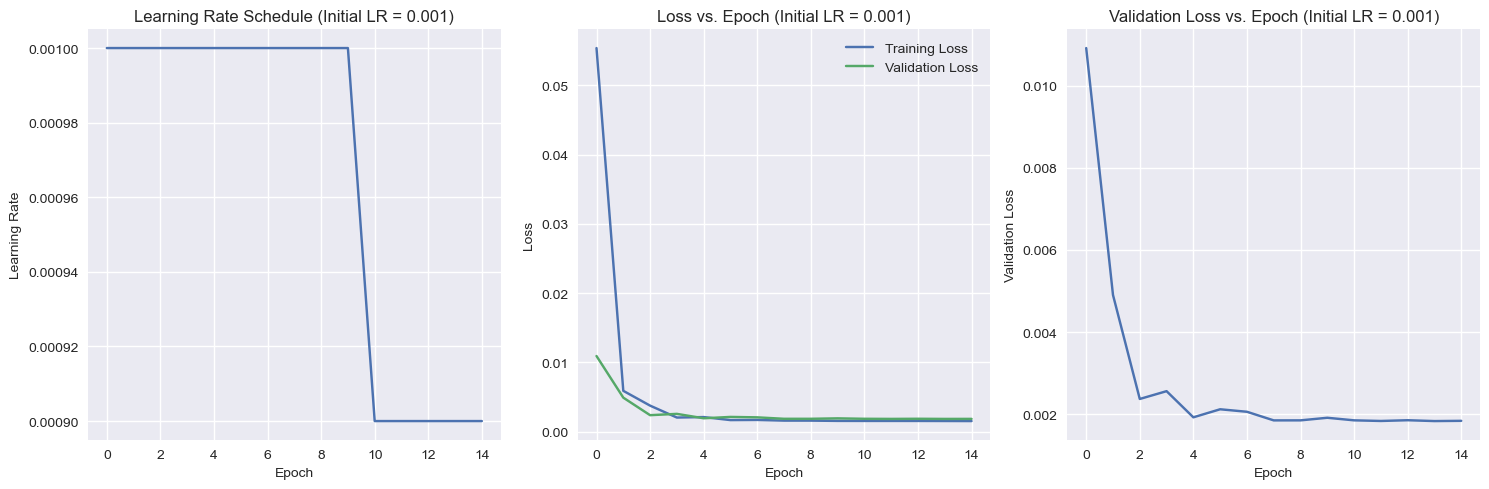

/Users/inderkaur/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop training after no improvement for 10 epochs
restore_best_weights=False,  # Restore the best weights when stopping
min_delta=0.0001)

checkpont_rnn = ModelCheckpoint(
    filepath='best_model_daily_multiple_features',
    save_weights_only=False,
    save_freq = 'epoch',
    monitor = 'val_loss',
    mode='min',
    save_best_only = True,
    verbose = 1)

# Initialize lists to store loss and learning rates
losses = []
learning_rates = []

# Custom callback to log loss and learning rate
class LossLearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        loss = logs['loss']
        learning_rates.append(lr)
#         print(learning_rates)
        losses.append(loss)
        print()
#         print(f"Learning Rate = {lr.numpy()}")
        print(f"Epoch {epoch+1}: Learning Rate = {lr.numpy()}, Loss = {loss}")
# 

# Create an instance of the custom callback
loss_lr_callback = LossLearningRateCallback()

def build_model(initial_lr=0.001):
    model_1 = Sequential([
#     BatchNormalization(
#         input_shape = (window_size,num_features),
#         name = 'Batch_Norm_1'),
    LSTM(128,return_sequences=True,name='LSTM_1',input_shape = (window_size,num_features)),
    
    LSTM(64,name='LSTM_2'),
    Dense(50,activation='relu',name='Dense_1'),
    Dense(len(tickers),name='Returns')
])
        
        
        
    optimizer = Adam(learning_rate=initial_lr)
    
    model_1.compile(
    loss=tf.keras.losses.Huber(),
    metrics=[tf.metrics.RootMeanSquaredError(),'mae'],
    optimizer=optimizer)
    
    return model_1


def lr_schedule(epoch, initial_lr=0.01, decay_factor=0.9, decay_epochs=10):
    if epoch<decay_epochs:
        return initial_lr
    elif epoch%decay_epochs!=0:
        return initial_lr
    else:
        return initial_lr * (decay_factor ** (epoch // decay_epochs))

# learning schedule callback
lr_rate = LearningRateScheduler(lr_schedule)
# print(lr_rate.numpy())
callbacks_list = [lr_rate,loss_lr_callback, early_stopping, checkpont_rnn]
callbacks_list



# Define a list to store validation losses for each learning rate


# List of initial learning rates to try
initial_learning_rates = [0.001]


best_model = None
best_val_loss = float('inf')
validation_losses = []
num_epochs=100
for lr in initial_learning_rates:
    
    print(f"\nTraining with initial learning rate: {lr}")
    model_1 = build_model(initial_lr=lr)
    print(model_1.summary())

    history = model_1.fit(my_window.train,
                          epochs=num_epochs,
                          callbacks=callbacks_list,
                          verbose=1,
                          validation_data=my_window.val)
    
    # Get the final validation loss for this learning rate
    # Get the final validation loss for this learning rate
    final_val_loss = history.history['val_loss'][-1]
    validation_losses.append(final_val_loss)

    last_epoch = len(history.history['loss'])

# plt.plot(np.arange(1, last_epoch+1), history.history['loss'], label='Loss', lw=3)
# plt.plot(np.arange(1, last_epoch+1), history.history['val_loss'], label='val_loss', lw=3)


    # Plot learning rate vs. epoch
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(len(history.history['loss'])), history.history['lr'])
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title(f'Learning Rate Schedule (Initial LR = {lr})')

    # Plot epoch vs. loss
    plt.subplot(1, 3, 2)
    plt.plot(range(len(history.history['loss'])), history.history['loss'], label='Training Loss')
    plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss vs. Epoch (Initial LR = {lr})')

    # Plot epoch vs. validation loss
    plt.subplot(1, 3, 3)
    plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title(f'Validation Loss vs. Epoch (Initial LR = {lr})')

    plt.tight_layout()
    plt.show()
    
    # Check if this model has the best validation loss
    if final_val_loss < best_val_loss:
#         best_val_loss = final_val_loss
        best_lr = lr
        best_val_loss = final_val_loss
        best_model = model_1

# Save the best model
if best_model is not None:
    best_model.save('best_model_daily_multiple_features.h5')


In [33]:
print(f'\nBest Learning Rate: {best_lr}, Best Validation Loss: {best_val_loss}')



Best Learning Rate: 0.001, Best Validation Loss: 0.001839660108089447


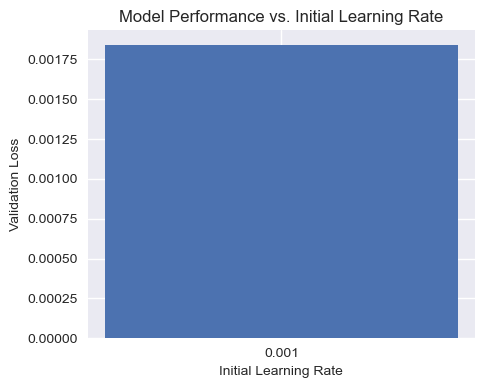

In [34]:
plt.figure(figsize=(5, 4))
# Plot the performance of each initial learning rate
plt.bar([str(lr) for lr in initial_learning_rates], validation_losses)
plt.xlabel('Initial Learning Rate')
plt.ylabel('Validation Loss')
plt.title('Model Performance vs. Initial Learning Rate')
plt.show()

In [35]:
[str(lr) for lr in initial_learning_rates], validation_losses

(['0.001'], [0.001839660108089447])

In [36]:
from tensorflow.keras.models import load_model

final_model = load_model('best_model_daily_multiple_features.h5')

In [37]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 5, 128)            106496    
                                                                 
 LSTM_2 (LSTM)               (None, 64)                49408     
                                                                 
 Dense_1 (Dense)             (None, 50)                3250      
                                                                 
 Returns (Dense)             (None, 5)                 255       
                                                                 
Total params: 159409 (622.69 KB)
Trainable params: 159409 (622.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
final_model.evaluate(my_window.test)

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 79), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 259ms/step - loss: 0.0013 - root_mean_squared_error: 0.0507 - mae: 0.0365


[0.0012873915256932378, 0.05074232444167137, 0.03653186559677124]

In [39]:
def plot_window(tickers,window_dataset,pandas_dataset,window_size,model,
                figsize=(10,7)):
    """This function plots the observed returns inside a tf.data.Dataset and
    compares them with the predicted returns of a model.

    Inputs:
    -------
    window_dataset (tensorflow.data.Dataset object): dataset with both inputs
        and target values.
    pandas_dataset (pandas DataFrame): dataframe that was used to create the
        window_dataset.
    window_size (int): window size used in the transformation from sequential 
        time series into window time series.
    model (model object): trained model with the capability to predict in a
        similar manner than tensorflow.keras.Model object.
    figsize (tuple, default=(12,100)): tuple with the dimensions of the figure
        where the data will be plotted.
    
    Ouputs:
    -------
    None
    """
    # Determine the X-axis of the plot:
    plot_index = pandas_dataset.iloc[window_size:,:].index

    # Assign in the addecuate format the values of the observed taget variable(s):
    y = np.concatenate([targets for inputs,targets in window_dataset],axis=0)
    
    # Use the model to predict the target variable(s):
    
    y_hat = model.predict(window_dataset)
    print("printing y hat of plot_window function")
    print(y_hat)
    # Adjust the shapes:
    y = y.reshape(y_hat.shape)
    print("printing y of plot_window function")
    print(y)

    # Plot the data:
    
#     for ticker in tickers:
#         print("&&&&&&&&&&&&&&&&&&")
#         print(ticker)
#         print(y_hat.shape[1])
    for n in range(y_hat.shape[1]):
        print(n)
        print(tickers[n])
        plt.figure(figsize=figsize)
        plt.subplot(y_hat.shape[1],1,n+1)
        plt.ylabel('Return')
        plt.plot(plot_index,y_hat[:,n],label='Predicted',color='maroon')
        plt.plot(plot_index,y[:,n],label='Observed',color='midnightblue',alpha=0.5)
        plt.title(tickers[n])
        plt.legend()

In [40]:
tickers

['BK', 'CTAS', 'T', 'CSCO', 'MRK']

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 79), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
6/6 [==============================] - 0s 8ms/step
printing y hat of plot_window function
[[0.5284966  0.53704315 0.36935002 0.51253766 0.5538013 ]
 [0.52666277 0.5353089  0.3683546  0.5074059  0.551104  ]
 [0.524241   0.5330663  0.36633533 0.50285053 0.54840755]
 ...
 [0.5363152  0.5415386  0.36103725 0.5135665  0.54393625]
 [0.53631395 0.5422745  0.3610853  0.51346546 0.54753655]
 [0.5374378  0.54200995 0.3616861  0.51503164 0.54884917]]
printing y of plot_window function
[[0.5255143  0.55510587 0.41913956 0.5478724  0.5251003 ]
 [0.5303201  0.5549786  0.37459096 0.50054026 0.56910974]
 [0.55136853 0.5496276  0.4004964  0.5683615  0.50574744]
 ...
 [0.5333692  0.54787815 0.44437602 0.6653922  0.56275916]
 [0.53146696 0.50978184 0.36095816 0.5057779  0.540093  ]
 [0.52445805 0.52065945 0.

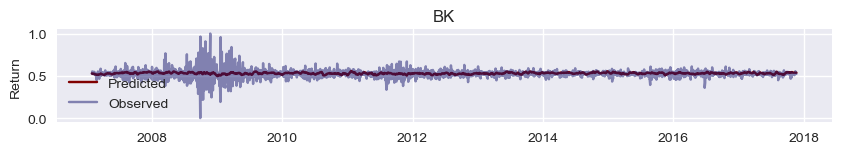

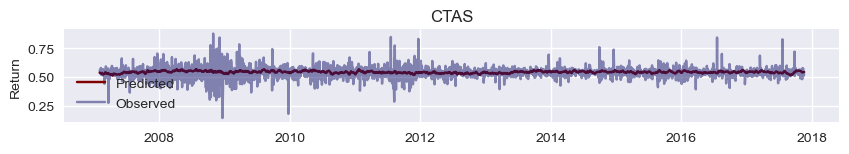

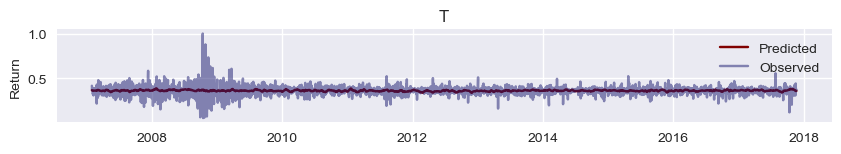

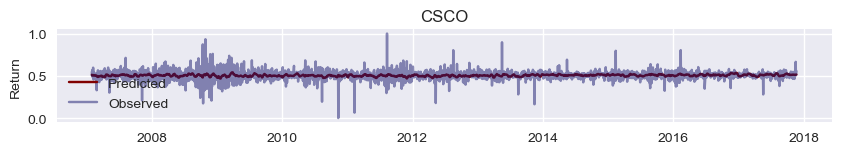

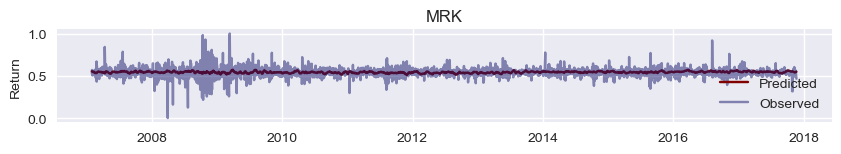

In [41]:
############# Training Results
# Create new WindowGenerator with the data not shuffled:
my_window_2 = WindowGenerator(
    input_width=window_size,
    label_width=1,
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=label_cols,
    batch_size=batch_size,
    shuffle=False)

plot_window(tickers,my_window_2.train,train_df,window_size,final_model)

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 79), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 33ms/step
printing y hat of plot_window function
[[0.53497183 0.5472713  0.37759355 0.5048453  0.5597441 ]
 [0.5320835  0.54049027 0.37356475 0.50259566 0.5537231 ]
 [0.52906376 0.53535753 0.37292975 0.50129384 0.5479897 ]
 ...
 [0.5149777  0.5331229  0.3694356  0.51259935 0.5724286 ]
 [0.5123143  0.5288216  0.3696999  0.50651586 0.5699982 ]
 [0.50965744 0.52690274 0.3726118  0.5039375  0.5697956 ]]
printing y of plot_window function
[[0.5413804  0.6829685  0.342973   0.53057283 0.5522304 ]
 [0.52262425 0.47384426 0.36072052 0.4846635  0.5821297 ]
 [0.5342343  0.56105286 0.35522833 0.49290013 0.50088775]
 ...
 [0.4839216  0.6152627  0.3391005  0.47710267 0.5423904 ]
 [0.6639562  0.5443571  0.40834922 0.558401   0.5801102 ]
 [0.4942527  0.4585344  0

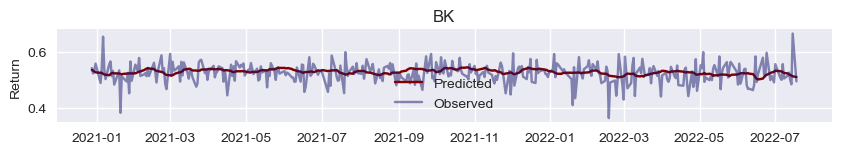

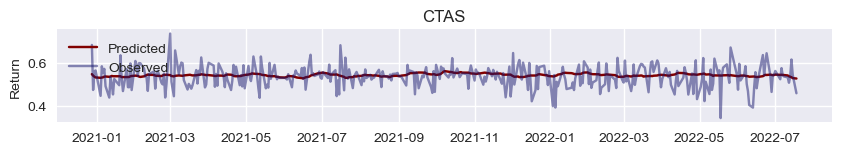

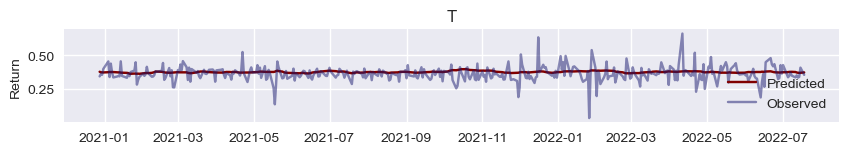

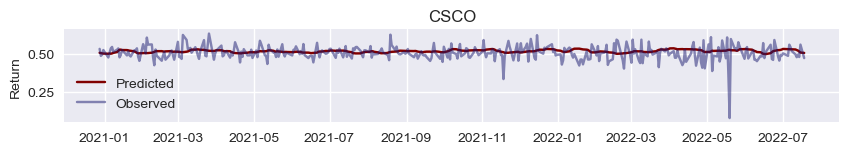

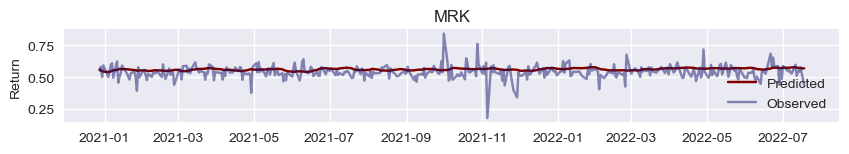

In [42]:
plot_window(tickers,my_window_2.test,test_df,window_size,final_model)

In [43]:
def optimize_portfolio(returns,guess_weights=None,rfr=0):
    """This function optimizes the weight allocation for the assets in a
    portfolio, represented by the returns.

    Inputs:
    -------
    returns (pandas DataFrame|Series): contains the returns information.
    guess_weights (list of numerical values, default=None): guess values for
        the weights of the different assets in the portfolio.
    short (boolena, default=True): define ifshort possitions are allowed or 
        not.
    rfr (numerical value, default=0): risk free rate, could be a series of
        the same length as returns.

    Outputs:
    --------
    opt_weights (array-like object): array with the optimal weights for the
        portfolio.
    """
    # Define important variables:
#     print("KIIIIIIII")
    num_assets = returns.shape[1]
    if isinstance(guess_weights,type(None)):
        guess_weights = [1/num_assets for i in range(num_assets)]

    # Define bound if short possitions are allowed or not:
    
    bounds = [(0,1) for i in range(num_assets)]
    

    # Define constraints, if there can or not be leverage
    weights_sum_to_1 = {'type':'eq',
                        'fun':lambda weights: np.sum(np.absolute(weights))-1}
#     print("sharpe ratio:::::::::::")
#     print(sharpe_ratio)
#     print("returns:::::::::::::::")
#     print(returns)
    # Minimize the function:
    opt_weights = spo.minimize(
        sharpe_ratio,
        guess_weights,
        args = (rfr, True, returns),
        method = 'SLSQP',
        options = {'disp':False},
        constraints = (weights_sum_to_1),
        bounds = bounds
    )

    return opt_weights 

In [44]:
def daily_rate(x, periods_year=252):
    """This function transforms a rate into a daily rate

    Inputs:
    -------
    x (numerical value): rate that you want to transform into a daily rate.
    periods_year (numerical value, default=252): amount of periods per year
        of the periodicity of rate x.
    
    Ouputs:
    -------
    df (numerical value): daily rate
    """
    dr = np.power(1+x,1/periods_year)-1
    return dr

In [45]:
def sharpe_ratio(weights=None, rfr=0, negative=False, returns=0):
    """Compute the Sharpe Ratio of a portfolio.

    Inputs:
    -------
    weights (list of numerical values, default=None): list with the weights
        of the assets in the portfolio.
    rfr (numerical value|array-like, default=0): risk-free rate.
    returns (pandas DataFrame|Series, default=0): returns of the assets in
        the portfolio.

    Outputs:
    --------
    sharpe_ratio (numerical value): Sharpe ratio of the portfolio.
    """
    # Define important variables:
    num_assets = returns.shape[1]
    if isinstance(weights,type(None)):
        weights = [1/num_assets for i in range(num_assets)]

    # Get portfolio returns:
    portfolio_returns = (returns*weights).sum(axis=1)
    portfolio_std = portfolio_returns.std()

    # Compute Sharpe Ratio formula:
    sharpe_ratio = (portfolio_returns-rfr).mean()/portfolio_std

    # If used in a minization process:
    if negative:
        sharpe_ratio *= -1

    return sharpe_ratio    

In [46]:
columns = ['FR_'+ticker for ticker in tickers]
y_train = final_model.predict(my_window_2.train)
y_val = final_model.predict(my_window_2.val)
y_test = final_model.predict(my_window_2.test)
y_hat_total = np.concatenate([y_train,y_val,y_test],axis=0)
ret_hat_df = pd.DataFrame(data=y_hat_total,index=model_data.index[5:],columns=columns)
rfr = data_quandl['3m_rate'].agg(daily_rate)
ret_hat_df = ret_hat_df.merge(rfr.rename('rfr'),left_index=True,right_index=True,
                             how='left')

opt_weights = np.array([optimize_portfolio(
    returns = window[ret_hat_df.columns[:-1]],
    rfr = window[ret_hat_df.columns[-1]]).x for window in ret_hat_df.rolling(40)])
opt_weights.shape

# opt_weights = np.array([optimize_portfolio(
#     returns=ret_hat_df[ret_hat_df.columns[:-1]],  # Exclude 'rfr' column
#     rfr=ret_hat_df['rfr']
# ).x])

# opt_weights = opt_weights.squeeze()  # Remove extra dimension if it exists

# Display the shape of opt_weights
print(f"Shape of optimized weights: {opt_weights.shape}")


************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 79), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
6/6 [==============================] - 0s 9ms/step
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 79), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
2/2 [==============================] - 0s 6ms/step
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 79), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 37ms/step
Shape of optimized weights: (3893, 5)


In [47]:
model_data.shape

(3898, 79)

In [48]:
opt_weights

array([[2.00000000e-01, 2.00000000e-01, 2.00000000e-01, 2.00000000e-01,
        2.00000000e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.10233794e-10, 1.00000000e+00, 7.07961467e-11, 0.00000000e+00,
        3.83048038e-11],
       ...,
       [3.04232888e-13, 3.78327783e-01, 4.97727675e-01, 0.00000000e+00,
        1.23944542e-01],
       [0.00000000e+00, 2.06056939e-01, 5.39841944e-01, 1.00948504e-12,
        2.54101118e-01],
       [3.35262483e-12, 1.03140340e-01, 5.74218043e-01, 0.00000000e+00,
        3.22641617e-01]])